In [1]:
import polars as pl
import pandas as pd
import os

In [2]:
Depth_0 = pl.read_parquet("C:\\Users\\afise\\.git\\CreditRiskModel\\Merged_Data\\train_DEPTH_0.parquet")
Depth_1 = pl.read_csv("Merged_Data/train_DEPTH_1.csv")
Depth_2 = pl.read_csv("Merged_Data/train_DEPTH_2.csv")

In [3]:
Internal_Final = Depth_0.join(
    Depth_1,
    on='case_id',
    how='left'
)

In [4]:
Internal_Final = Internal_Final.join(
    Depth_2,
    on='case_id',
    how='left'
)

df = Internal_Final

In [5]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

df = df.to_pandas()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [6]:
X = df.drop(['target', 'case_id'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [7]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

In [8]:
%%time

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'num_leaves': 25,
    'min_data_in_leaf': 100,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 1,
    'n_jobs': -1
}

num_round = 100

callbacks = [
    lgb.early_stopping(stopping_rounds=10, verbose=True)
]

bst = lgb.train(params,
                train_data,
                num_boost_round=num_round,
                valid_sets=[valid_data],
                callbacks=callbacks)

[LightGBM] [Info] Number of positive: 38475, number of negative: 1182852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.222677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34674
[LightGBM] [Info] Number of data points in the train set: 1221327, number of used features: 293
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031503 -> initscore=-3.425675
[LightGBM] [Info] Start training from score -3.425675
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.815379	valid_0's binary_logloss: 0.117058
CPU times: total: 4min 42s
Wall time: 23.4 s


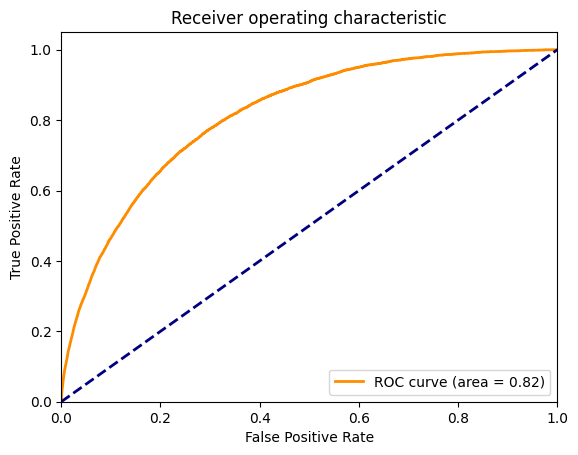

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = bst.predict(X_test) # type: ignore
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

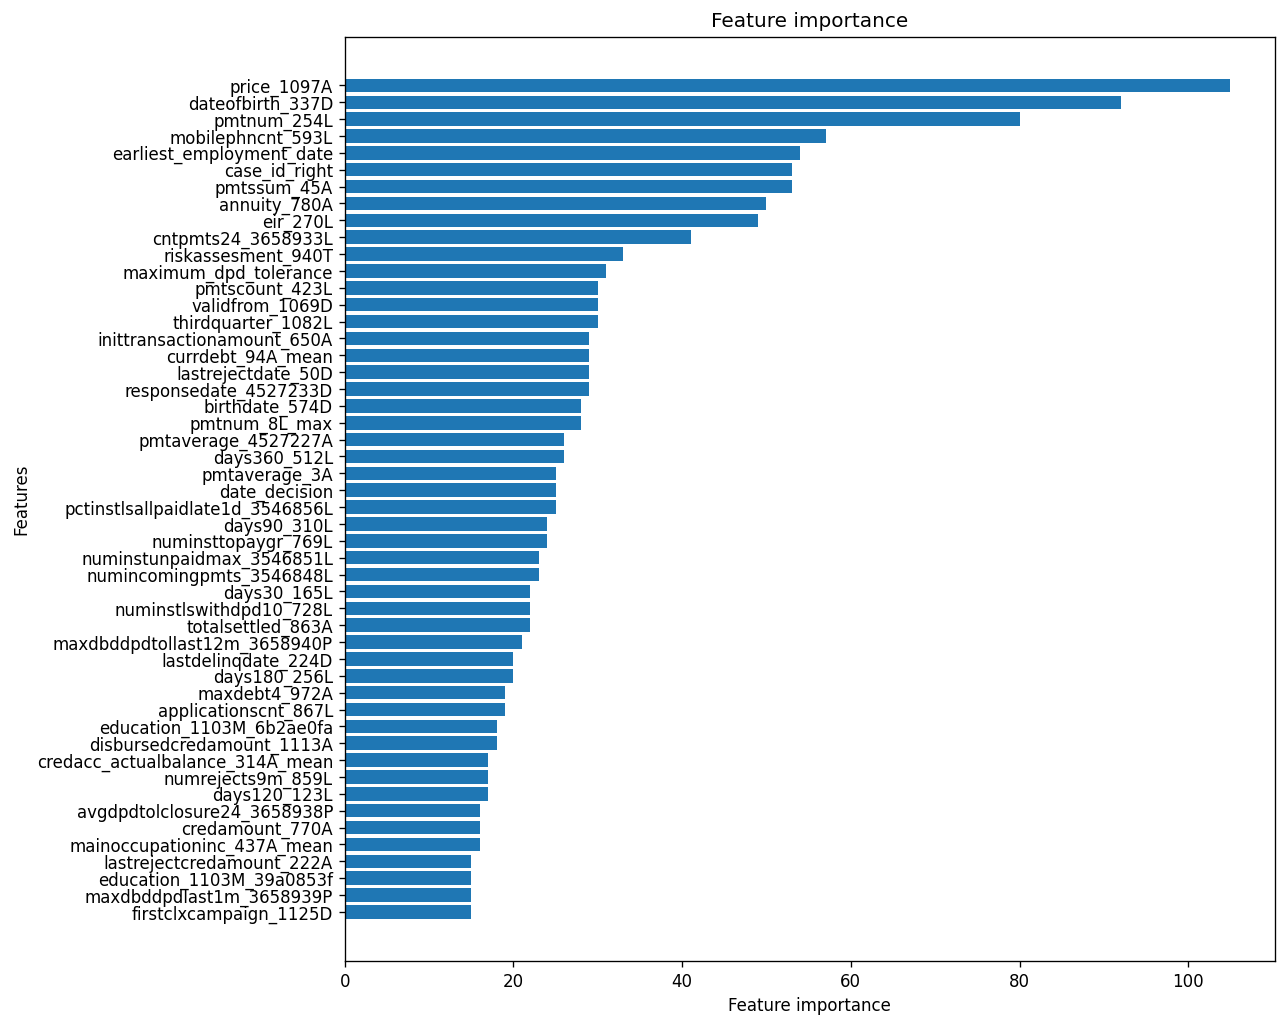

In [10]:
feature_imp = bst.feature_importance(importance_type='split') # type: ignore
feature_names = bst.feature_name() # type: ignore

importance_df = pd.DataFrame({'Features': feature_names, 'Importance': feature_imp})
importance_df = importance_df.sort_values('Importance', ascending=False)

top_features = 50

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(importance_df['Features'][:top_features], importance_df['Importance'][:top_features])
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.title('Feature importance')
plt.gca().invert_yaxis()
plt.show()